In [1]:
import datetime
import math

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import warnings

from matplotlib import pyplot as plt
from scipy import optimize, special, stats

from models.cir import CoxIngersollRossModel
from models.range_accrual import range_accrual_pricing

warnings.simplefilter('ignore', FutureWarning)

%load_ext autoreload
%autoreload 2

In [2]:
# Заранее выгруженные данные из интернета помещаем в датафреймы
fx_rate = pd.read_csv('./data_processing/data/Rtsudcur.csv', sep=';')
mosprime = pd.read_csv('./data_processing/data/2018-07-01_2021-12-10.csv', sep=';')
sofr = pd.read_csv('./data_processing/data/SOFR.csv')

# Преобразовываем имя колонок
fx_rate.rename(columns={'#Date':'Date', 'Value 18:50 MSK':'FX-Rate'}, inplace=True)
mosprime = mosprime[['Date', 'RUR']]
sofr.rename(columns={'DATE':'Date', 'SOFR':'USD'}, inplace=True)

# Столбец с датой преобразовываем в тип даты
fx_rate['Date'] = pd.to_datetime(fx_rate['Date'], format='%Y-%m-%d')
mosprime['Date'] = pd.to_datetime(mosprime['Date'], format='%d-%m-%Y')
sofr['Date'] = pd.to_datetime(sofr['Date'], format='%Y-%m-%d')

# Чистка от пропусков, замена запятой на точку у float
mosprime['RUR'] = mosprime['RUR'].str.replace(',', '.')
mosprime = mosprime[~mosprime['RUR'].isin(['-', '--'])]
sofr = sofr[sofr['USD'] != '.']
mosprime['RUR'] = mosprime['RUR'].astype('float')
sofr['USD'] = sofr['USD'].astype('float')

# Двумя последовательными inner join создаем dataframe со всеми
# историческими данными до даты начала симулирования 2021-12-10 и совпадающими днями
df1 = pd.merge(fx_rate, mosprime, left_on='Date', right_on='Date', how='inner')
fx_rate_info = pd.merge(df1, sofr, left_on='Date', right_on='Date', how='inner')
fx_rate_info.head()

,Date,FX-Rate,RUR,USD
0,2021-12-10,73.4720,7.69,0.05
1,2021-12-09,73.5831,7.72,0.05
2,2021-12-08,73.7115,7.68,0.05
3,2021-12-07,74.0764,7.51,0.05
4,2021-12-06,73.9960,7.59,0.05


In [3]:
fx_rate_info['Date'].max(), fx_rate_info.isna().sum()

(Timestamp('2021-12-10 00:00:00'),
 Date       0
 FX-Rate    0
 RUR        0
 USD        0
 dtype: int64)

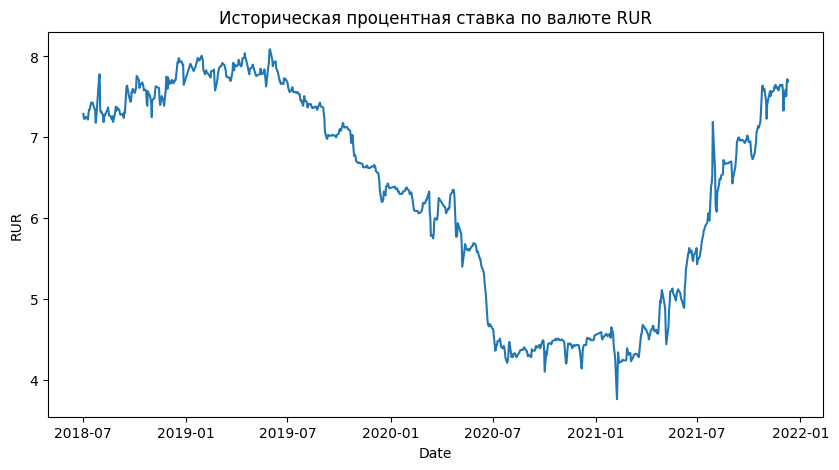

In [4]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=fx_rate_info, x='Date', y='RUR')
plt.title('Историческая процентная ставка по валюте RUR')
plt.show();

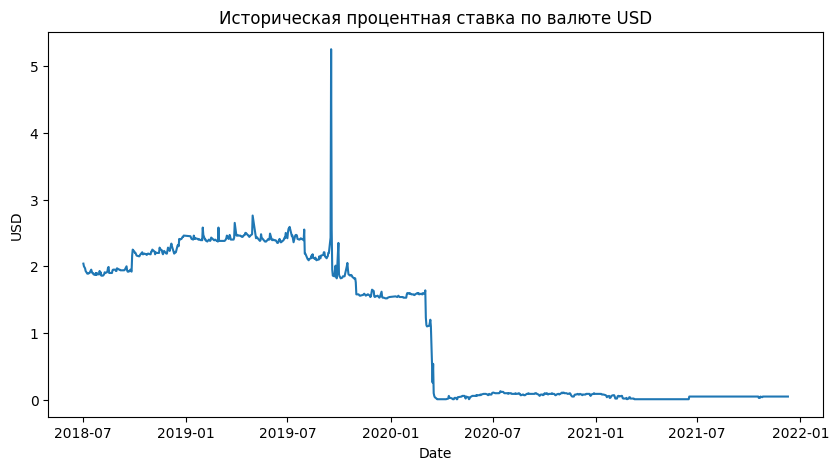

In [5]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=fx_rate_info, x='Date', y='USD')
plt.title('Историческая процентная ставка по валюте USD')
plt.show();

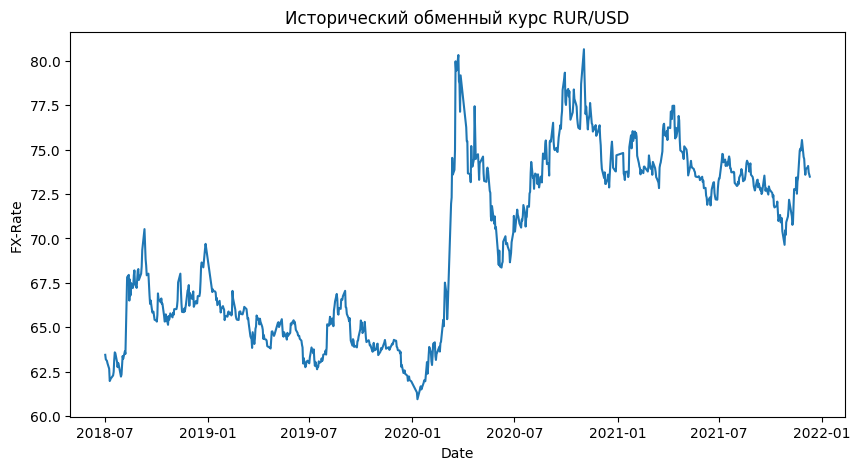

In [6]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=fx_rate_info, x='Date', y='FX-Rate')
plt.title('Исторический обменный курс RUR/USD')
plt.show();

In [7]:
history_data = fx_rate_info

'''
За начало действия контракта принимаем дату начала симулирования - 10.12.2021
Дата окончания контракта задается вручную
Кол-во наблюдений (n_fix_dates) считаем как кол-во рабочих дней (согласно numpy)
между датой окончания и датой начала контракта
Шаг считается как 1 / n_fix_dates
'''

year, month, day = list(map(int, input('Введите год, месяц, день окончания контракта (Через пробел):').split()))
notional = float(input('Введите номинал контракта:'))
upper_bound = float(input('Введите верхнюю границу контракта (0 если границы нет):'))
lower_bound = float(input('Введите нижнюю границу контракта:'))

start_date = datetime.date(2021, 12, 10)
end_date = datetime.date(year, month, day)
n_fix_dates = np.busday_count(start_date, end_date)

chol_data = history_data[history_data['Date'] >= datetime.datetime(2021, 1, 1)]
chol_matrix = np.linalg.cholesky(chol_data.corr(numeric_only=True))

fair_value_list = []
mean_list = []

n_simulations = 100 # минимальное кол-во симуляций, с которого мы начинаем
iteration = 1 # номер итерации
'''
запускаем бесконечный цикл, условием выхода из которого ставим, что среднее значение payout начнет
очень медленно изменяться. В конце каждой итерации сохранеям симуляции, значение payout и изменяем
кол-во симуляций на 1 больше
Когда условие выхода из цикла будет выполнено значение переменной fair_value 
будет нашей справедливой стоимостью
'''
while True:
    corr_simulated_usd_rate, corr_simulated_rur_rate, corr_simulated_fx_rate, fair_value = range_accrual_pricing(
        history_data, n_simulations, n_fix_dates, chol_matrix, notional, upper_bound, lower_bound
    )

    fair_value_list.append(fair_value)
    
    if iteration > 1:
        mean_previous = np.array(fair_value_list[:-1]).mean()  
        mean_current = np.array(fair_value_list).mean() 
        mean_list.append(mean_current)
        if np.abs(mean_current - mean_previous) < 0.000005 * notional:
            break

    n_simulations += 1
    iteration += 1

fair_value = round(fair_value, 2)
print(f'\n Справедливая стоимость Range Accrual с номиналом {notional} \n и временем действия контракта {n_fix_dates} дней равна {fair_value}')

Введите год, месяц, день окончания контракта (Через пробел): 2022 3 3
Введите номинал контракта: 100
Введите верхнюю границу контракта (0 если границы нет): 85
Введите нижнюю границу контракта: 50



 Справедливая стоимость Range Accrual с номиналом 100.0 
 и временем действия контракта 59 дней равна 71.55


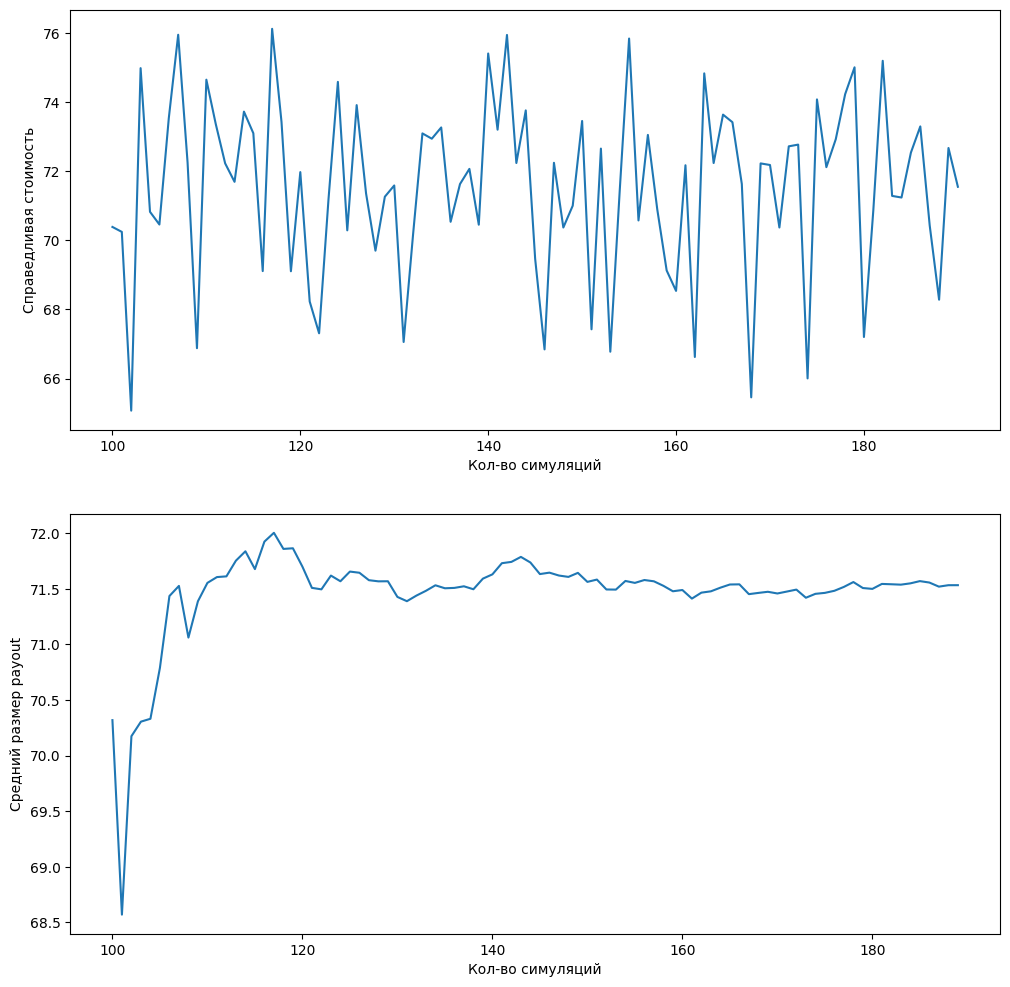

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(12, 12))
axs[0].plot(range(100, n_simulations + 1), fair_value_list)
axs[0].set_ylabel('Справедливая стоимость')
axs[0].set_xlabel('Кол-во симуляций')

axs[1].plot(range(100, n_simulations), mean_list)
axs[1].set_ylabel('Средний размер payout')
axs[1].set_xlabel('Кол-во симуляций')

plt.show();

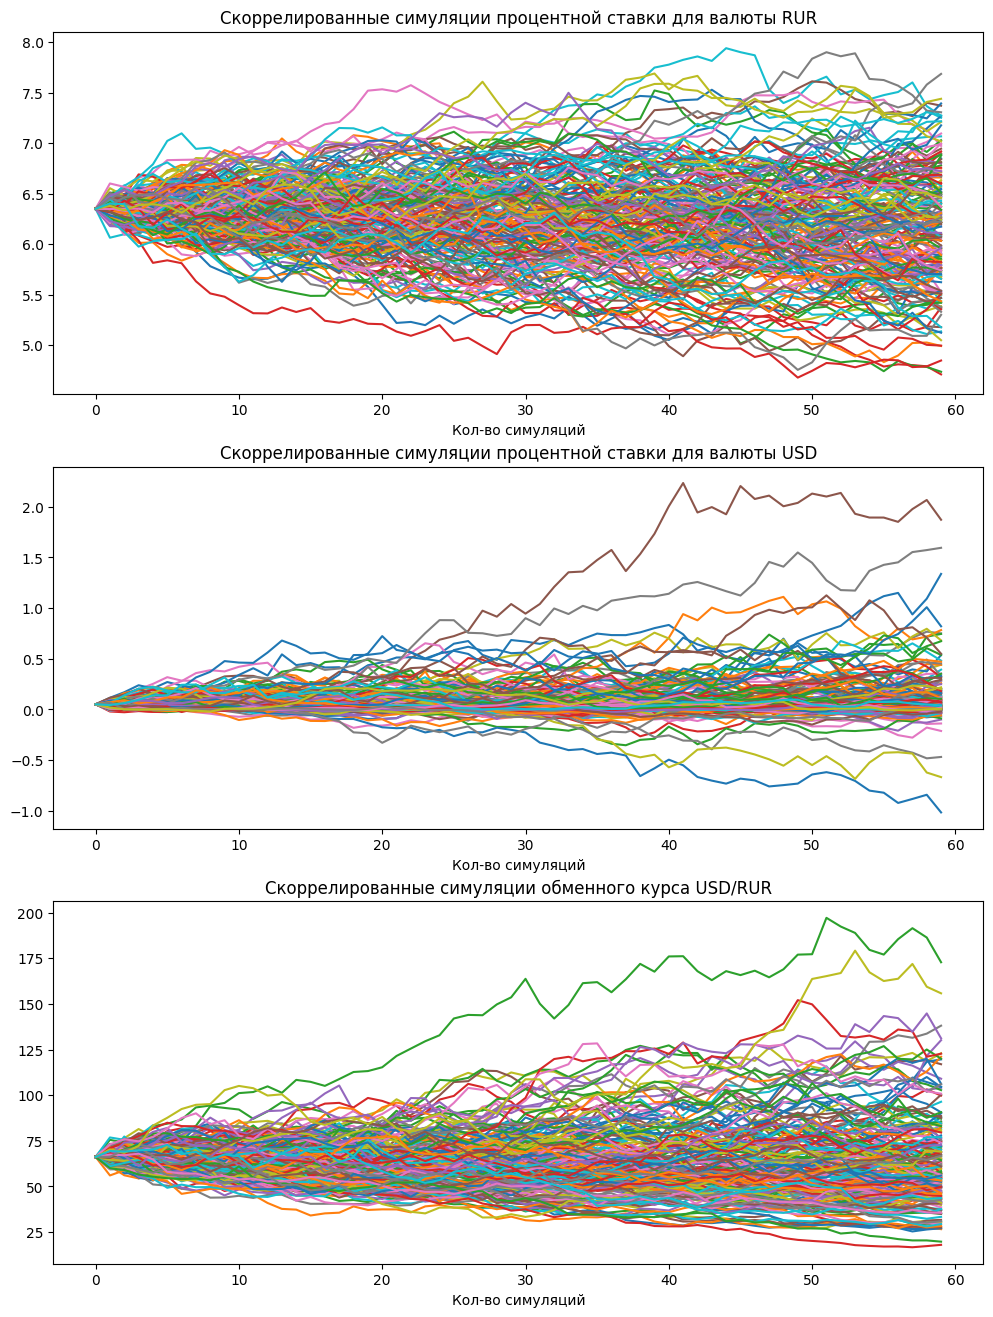

In [9]:
fig, axs = plt.subplots(3, 1, figsize=(12, 16))

for simulation in corr_simulated_rur_rate.T:
    axs[0].plot(np.arange(0, n_fix_dates + 1, 1), simulation)
axs[0].set_title('Скоррелированные симуляции процентной ставки для валюты RUR')
axs[0].set_xlabel('Кол-во симуляций')

for simulation in corr_simulated_usd_rate.T:
    axs[1].plot(np.arange(0, n_fix_dates + 1, 1), simulation)
axs[1].set_title('Скоррелированные симуляции процентной ставки для валюты USD')
axs[1].set_xlabel('Кол-во симуляций')

for simulation in corr_simulated_fx_rate.T:
    axs[2].plot(np.arange(0, n_fix_dates + 1, 1), simulation)
axs[2].set_title('Скоррелированные симуляции обменного курса USD/RUR')
axs[2].set_xlabel('Кол-во симуляций')

plt.show()